# Supervised learning classification example using convolution neural network with Keras & Keras Tuner on the MNIST dataset.

#Check GPU.

In [ ]:
!nvidia-smi

#Install Keras tuner.

In [ ]:
!pip install keras-tuner

#Imports.

In [ ]:
import numpy
import matplotlib.pyplot as plt
from keras import backend as K
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers.core import Activation

import kerastuner
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

from keras.utils import np_utils

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [ ]:
K.set_image_data_format('channels_last')
numpy.random.seed(0)

#Load MNIST dataset.

In [ ]:
#get the dataset
(xTrain, YTrain), (xTest, YTest) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


##Display samples of MNIST data.

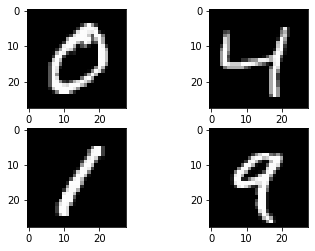

In [ ]:
#Plot out the images as gray scale
plt.subplot(221)
plt.imshow(xTrain[1], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(xTrain[2], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(xTrain[3], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(xTrain[4], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Data Exploration
print("Number of training examples = {}".format(xTrain.shape[0]))
print("Number 0f training classses = {}".format(len(numpy.unique(YTrain))))
print("Dimension of images = {}, {}".format(xTrain[2].shape[0],xTrain[2].shape[1]))

Number of training examples = 60000
Number 0f training classses = 10
Dimension of images = 28, 28


#Normalize image channel values & one-hot encode labels.

In [ ]:
#Prepare the data
#Normalise the data
xTrain = xTrain/255
xTest = xTest/255

xTrain = xTrain.reshape(xTrain.shape[0], 28, 28, 1).astype('float32')
xTest = xTest.reshape(xTest.shape[0], 28, 28, 1).astype('float32')

YTrain = np_utils.to_categorical(YTrain)
YTest = np_utils.to_categorical(YTest)

#Neural network model building using Keras tuner.

In [ ]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()
    
    model.add(Conv2D(filters=hp.Int('input_units',
                                    min_value=8,
                                    max_value=64,
                                    step=16),
                     kernel_size=5,
                     input_shape=xTrain.shape[1:],
                     padding='same', 
                     activation='relu',
                     ))
    
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    for i in range(hp.Int('n_layers', 1, 5)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten()) 
    model.add(Dense(10))      # 10 probablity outputs.
    model.add(Activation("softmax"))

    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss="categorical_crossentropy",
        metrics=['accuracy', 
                 'AUC',
                 'Precision',
                 'Recall',
                 'TruePositives',
                 'FalsePositives',
                 'TrueNegatives',
                 'FalseNegatives',])
    
    return model

#Train the model & perform auto hyperparameter tuning with Keras tuner.

In [ ]:
#hypermodel = MyHyperModel(num_classes=10)

dir = '/content/drive/My Drive/Colab Notebooks/applied_AI_ML/'
proj_name = 'CA2'

tuner = RandomSearch(
    build_model,
    #objective='val_accuracy',
    objective=kerastuner.Objective('val_auc', direction='max'),     # See [3] under references.
    max_trials=5,
    directory=dir,
    project_name=proj_name)

tuner.search(xTrain, 
             YTrain,
             epochs=10,
             validation_split=0.1,
             batch_size=200, 
             )

Trial 5 Complete [00h 00m 49s]
val_auc: 0.9993804693222046

Best val_auc So Far: 0.999698281288147
Total elapsed time: 00h 04m 14s
INFO:tensorflow:Oracle triggered exit


##Display hyperparameters for top performing models.

In [ ]:
models = tuner.get_best_models(num_models=2)

tuner.results_summary()

#Model evaluation with test set.

In [ ]:
scores = models[0].evaluate(xTest, YTest, verbose=10)
print(scores)     # Metrics

[0.02618325501680374, 0.991100013256073, 0.9995929002761841, 0.99149489402771, 0.9908999800682068, 9909.0, 85.0, 89915.0, 91.0]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[2] [[1.5518416e-10 2.2746975e-09 1.0000000e+00 1.4078760e-13 2.0437555e-14
  4.0187546e-15 1.2526973e-09 8.8077046e-11 6.4963764e-11 2.7617247e-12]]


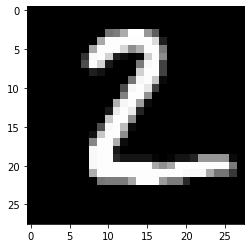

In [ ]:
#Show some results from the testing data
from keras.preprocessing.image import img_to_array, load_img
test_index = 1
#plot the image
plt.imshow(xTest[test_index].reshape(28,28), cmap= plt.get_cmap('gray'))
x = img_to_array(xTest[test_index])
x = numpy.expand_dims(x,axis=0)
preds = models[0].predict_classes(x)
prob = models[0].predict_proba(x)
print(preds, prob)

##Testing using other web images.

In [ ]:
from google.colab import files
file = files.upload()

Saving Screenshot 2021-04-26 180151.png to Screenshot 2021-04-26 180151.png


[8] [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


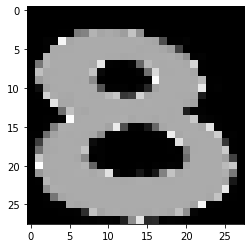

In [ ]:
img = []
fn = ""
for key in file.keys():
  fn = key
  img = load_img(path=fn, target_size=(28,28,1), color_mode="grayscale")
  img = numpy.invert(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
x = img_to_array(img)
x = numpy.expand_dims(x,axis=0)
preds = models[0].predict_classes(x)
prob = models[0].predict_proba(x)
print(preds, prob)

#References

1. [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

2. [An Empirical Comparison of Optimizers for Machine Learning Models](https://heartbeat.fritz.ai/an-empirical-comparison-of-optimizers-for-machine-learning-models-b86f29957050)

3. [Keras API reference / Metrics](https://keras.io/api/metrics/)